# 特征工程

上一节虽然介绍了机器学习的基本理念，但是所有示例都假设已经拥有一个干净的 `[n_samples, n_features]` 特征矩阵。其实在现实工作中，数据很少会这么干净。  
因此，机器学习实践中更重要的步骤之一是**特征工程**（`feature engineering`）——找到与问题有关的任何信息，把它们转换成特征矩阵的数值。

本节将介绍特征工程的一些常见示例：表示**分类数据**的特征、表示**文本**的特征和表示**图像**的特征。  
另外，还会介绍提高模型复杂度的**衍生特征**和处理缺失数据的**填充**方法。  
这个过程通常被称为**向量化**，因为它把任意格式的数据转换成具有良好特性的向量形式。

## 1. 分类特征

一种常见的非数值数据类型是**分类**数据。  
例如，浏览房屋数据的时候，除了看到“房价”（price）和“面积”（rooms）之类的数值特征，还会有“地点”（neighborhood）信息，数据可能像这样：

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

你可能会把分类特征用映射关系编码成整数：

In [2]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3}

{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3}

但是，在 `Scikit-Learn` 中这么做并不是一个好办法：这个程序包的所有模块都有一个基本假设，那就是数值特征可以反映代数量（`algebraic quantities`）。  
因此，这样映射编码可能会让人觉得存在 `Queen Anne < Fremont < Wallingford`，甚至还有 `Wallingford - Queen Anne = Fremont`，这显然是没有意义的。

面对这种情况，常用的解决方法是**独热编码**。它可以有效增加额外的列，让 `0` 和 `1` 出现在对应的列分别表示每个分类值有或无。  
当你的数据是像上面那样的字典列表时，用 `Scikit-Learn` 的 `DictVectorizer` 类就可以实现：

In [3]:
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

你会发现，`neighborhood` 字段转换成三列来表示三个地点标签，每一行中用 `1` 所在的列对应一个地点。当这些分类特征编码之后，你就可以和之前一样拟合 `Scikit-Learn` 模型了。  
如果要看每一列的含义，可以用下面的代码查看特征名称：

In [4]:
# FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
# vec.get_feature_names()
vec.get_feature_names_out()

array(['neighborhood=Fremont', 'neighborhood=Queen Anne',
       'neighborhood=Wallingford', 'price', 'rooms'], dtype=object)

但这种方法也有一个显著的缺陷：如果你的分类特征有许多枚举值，那么数据集的维度就会**急剧**增加。然而，由于被编码的数据中有许多 `0`，因此用稀疏矩阵表示会非常高效：

In [5]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

在拟合和评估模型时，`Scikit-Learn` 的许多（并非所有）评估器都支持稀疏矩阵输入。  
`sklearn.preprocessing.OneHotEncoder` 和 `sklearn.feature_extraction.FeatureHasher` 是 `Scikit-Learn` 另外两个为分类特征编码的工具。

## 2. 文本特征

另一种常见的特征工程需求是将文本转换成一组数值。  
例如，绝大多数社交媒体数据的自动化采集，都是依靠将文本编码成数字的技术手段。  
数据采集最简单的编码方法之一就是**单词统计**：给你几个文本，让你统计每个词出现的次数，然后放到表格中。

In [6]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

面对单词统计的数据向量化问题时，可以创建一个列来表示单词“problem”、单词“evil”和单词“horizon”等。  
虽然手动做也可以，但是用 `Scikit-Learn` 的 `CountVectorizer` 更是可以轻松实现：

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

结果是一个稀疏矩阵，里面记录了每个短语中每个单词的出现次数。如果用带列标签的 `DataFrame` 来表示这个稀疏矩阵就更方便了：

In [8]:
import pandas as pd

# pd.DataFrame(X.toarray(), columns=vec.get_feature_names())  # FutureWarning: Function get_feature_names is deprecated;
pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


不过这种统计方法也有一些问题：原始的单词统计会让一些常用词聚集太高的权重，在分类算法中这样并不合理。  
解决这个问题的方法就是通过 **TF–IDF**（`term frequency–inverse document frequency`，词频逆文档频率），通过单词在文档中出现的频率来衡量其权重 。  
计算这些特征的语法和之前的示例类似：

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform(sample)
# pd.DataFrame(X.toarray(), columns=vec.get_feature_names())  # FutureWarning: Function get_feature_names is deprecated;
pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## 3. 图像特征

机器学习还有一种常见需求，那就是对图像进行编码。我们在 5.2 节处理手写数字图像时使用的方法，是最简单的图像编码方法：用像素表示图像。但是在其他类型的任务中，这类方法可能不太合适。

## 4. 衍生特征

还有一种有用的特征是输入特征经过数学变换衍生出来的新特征。我们在 5.3 节从输入数据中构造多项式特征时，曾经见过这类特征。  
我们发现将一个线性回归转换成多项式回归时，并不是通过改变模型来实现，而是通过改变输入数据！  
这种处理方式有时被称为**基函数回归**（`basis function regression`）。

例如，下面的数据显然不能用一条直线描述：

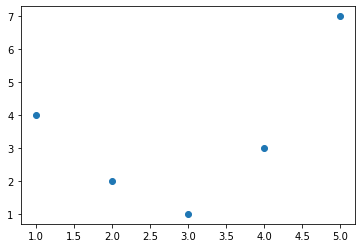

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y)

但是我们仍然用 `LinearRegression` 拟合出一条直线，并获得直线的最优解：

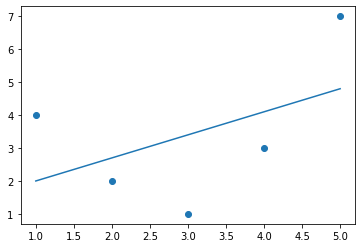

In [11]:
from sklearn.linear_model import LinearRegression

X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit)

很显然，我们需要用一个更复杂的模型来描述 `x` 与 `y` 的关系。可以对数据进行变换，并增加额外的特征来提升模型的复杂度。  
例如，可以在数据中增加多项式特征：

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


在衍生特征矩阵中，第 1 列表示 `x`，第 2 列表示 `x`<sup>2</sup>，第 3 列表示 `x`<sup>3</sup>。  
通过对这个扩展的输入矩阵计算线性回归，就可以获得更接近原始数据的结果了：

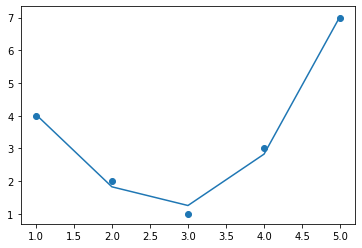

In [13]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit)

这种不通过改变模型，而是通过变换输入来改善模型效果的理念，正是许多更强大的机器学习方法的基础。  
5.6 节介绍**基函数回归**时将详细介绍这个理念，它通常被认为是强大的**核方法**（`kernel method`，5.7 节将详细介绍）技术的驱动力之一。

## 5. 缺失值填充

特征工程中还有一种常见需求是处理缺失值。例如，有如下一个数据集：

In [14]:
from numpy import nan

X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

当将一个普通的机器学习模型应用到这份数据时，首先需要用适当的值替换这些缺失数据。  
这个操作被称为缺失值**填充**，相应的策略很多，有的简单（例如用列均值替换缺失值），有的复杂（例如用矩阵填充或其他模型来处理缺失值）。  
复杂方法在不同的应用中各不相同，这里不再深入介绍。对于一般的填充方法，如均值、中位数、众数，`Scikit-Learn` 有 `Imputer` 类可以实现：

In [15]:
# from sklearn.preprocessing import Imputer  # ImportError: cannot import name 'Imputer' from 'sklearn.preprocessing'
from sklearn.impute import SimpleImputer

# imp = Imputer(strategy='mean')
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

我们会发现，结果矩阵中的两处缺失值都被所在列剩余数据的均值替代了。这个被填充的数据就可以直接放到评估器里训练了，例如 `LinearRegression` 评估器：

In [16]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])

## 6. 特征管道

如果经常需要手动应用前文介绍的任意一种方法，你很快就会感到厌倦，尤其是当你需要将多个步骤串起来使用时。  
例如，我们可能需要对一些数据做如下操作。
1. 用均值填充缺失值。
2. 将衍生特征转换为二次方。
3. 拟合线性回归模型。

为了实现这种管道处理过程，`Scikit-Learn` 提供了一个管道对象，如下所示：

In [17]:
from sklearn.pipeline import make_pipeline

# model = make_pipeline(Imputer(strategy='mean'), PolynomialFeatures(degree=2), LinearRegression())
model = make_pipeline(SimpleImputer(strategy='mean'), PolynomialFeatures(degree=2), LinearRegression())

这个管道看起来就像一个标准的 `Scikit-Learn` 对象，可以对任何输入数据进行所有步骤的处理：

In [18]:
model.fit(X, y)  # 和上面一样，X带有缺失值
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


这样的话，所有的步骤都会自动完成。请注意，出于简化演示考虑，将模型应用到已经训练过的数据上，模型能够非常完美地预测结果。